# run fair-2.1.3 with calibration 1.4.1

In [1]:
output_ensemble_size = 841

In [2]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

print("Running SSP scenarios...")

scenarios = [
    "ssp119",
    "ssp126",
    "ssp245",
    "ssp370",
    "ssp434",
    "ssp460",
    "ssp534-over",
    "ssp585",
]

df_solar = pd.read_csv(
    "../input/solar_erf_timebounds.csv", index_col="year"
)
df_volcanic = pd.read_csv(
    "../input/volcanic_ERF_1750-2101_timebounds.csv",
    index_col="timebounds",
)

solar_forcing = np.zeros(352)
volcanic_forcing = np.zeros(352)
volcanic_forcing[:352] = df_volcanic["erf"].loc[1750:2101].values
solar_forcing = df_solar["erf"].loc[1750:2101].values

df_methane = pd.read_csv(
    "../input/CH4_lifetime.csv", index_col=0,
)
df_configs = pd.read_csv(
    "../input/calibrated_constrained_parameters.csv", index_col=0,
)
df_landuse = pd.read_csv(
    "../input/landuse_scale_factor.csv", index_col=0,
)
df_lapsi = pd.read_csv(
    "../input/lapsi_scale_factor.csv", index_col=0,
)
valid_all = df_configs.index

trend_shape = np.ones(352)
trend_shape[:271] = np.linspace(0, 1, 271)

f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2101, 1)
f.define_scenarios(scenarios)
f.define_configs(valid_all)
species, properties = read_properties()
species.remove("Halon-1202")
species.remove("NOx aviation")
species.remove("Contrails")
f.define_species(species, properties)
f.allocate()

# run with harmonized emissions
da_emissions = xr.load_dataarray(
    "../input/ssps_harmonized_1750-2499.nc"
)

da = da_emissions.loc[dict(config="unspecified")][:351, ...]
fe = da.expand_dims(dim=["config"], axis=(2))
f.emissions = fe.drop("config") * np.ones((1, 1, output_ensemble_size, 1))

# solar and volcanic forcing
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

# climate response
fill(
    f.climate_configs["ocean_heat_capacity"],
    df_configs.loc[:, "clim_c1":"clim_c3"].values,
)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)  # not massively robust, since relies on kappa1, kappa2, kappa3 being in adjacent cols
fill(
    f.climate_configs["deep_ocean_efficacy"],
    df_configs["clim_epsilon"].values.squeeze(),
)
fill(
    f.climate_configs["gamma_autocorrelation"],
    df_configs["clim_gamma"].values.squeeze(),
)
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(
    f.species_configs["iirf_airborne"],
    df_configs["cc_rA"].values.squeeze(),
    specie="CO2",
)
fill(
    f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2"
)
fill(
    f.species_configs["iirf_temperature"],
    df_configs["cc_rT"].values.squeeze(),
    specie="CO2",
)

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_so2"].values.squeeze(),
    specie="Sulfur",
)
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_bc"].values.squeeze(),
    specie="BC",
)
fill(
    f.species_configs["aci_shape"],
    df_configs["aci_shape_oc"].values.squeeze(),
    specie="OC",
)

# methane lifetime baseline and sensitivity
fill(
    f.species_configs["unperturbed_lifetime"],
    df_methane.loc["historical_best", "base"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "CH4"],
    specie="CH4",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "N2O"],
    specie="N2O",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "VOC"],
    specie="VOC",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "NOx"],
    specie="NOx",
)
fill(
    f.species_configs["ch4_lifetime_chemical_sensitivity"],
    df_methane.loc["historical_best", "HC"],
    specie="Equivalent effective stratospheric chlorine",
)
fill(
    f.species_configs["lifetime_temperature_sensitivity"],
    df_methane.loc["historical_best", "temp"],
)

# correct land use  and LAPSI scale factor terms
fill(
    f.species_configs["land_use_cumulative_emissions_to_forcing"],
    df_landuse.loc["historical_best", "CO2_AFOLU"],
    specie="CO2 AFOLU",
)
fill(
    f.species_configs["lapsi_radiative_efficiency"],
    df_lapsi.loc["historical_best", "BC"],
    specie="BC",
)

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people
# might wanna run pulse expts with these gases)
fill(f.species_configs["baseline_emissions"], 38.246272, specie="CH4")
fill(f.species_configs["baseline_emissions"], 0.92661989, specie="N2O")
fill(f.species_configs["baseline_emissions"], 19.41683292, specie="NOx")
fill(f.species_configs["baseline_emissions"], 2.293964929, specie="Sulfur")
fill(f.species_configs["baseline_emissions"], 348.4549732, specie="CO")
fill(f.species_configs["baseline_emissions"], 60.62284009, specie="VOC")
fill(f.species_configs["baseline_emissions"], 2.096765609, specie="BC")
fill(f.species_configs["baseline_emissions"], 15.44571911, specie="OC")
fill(f.species_configs["baseline_emissions"], 6.656462698, specie="NH3")
fill(f.species_configs["baseline_emissions"], 0.92661989, specie="N2O")
fill(f.species_configs["baseline_emissions"], 0.02129917, specie="CCl4")
fill(f.species_configs["baseline_emissions"], 202.7251231, specie="CHCl3")
fill(f.species_configs["baseline_emissions"], 211.0095537, specie="CH2Cl2")
fill(f.species_configs["baseline_emissions"], 4544.519056, specie="CH3Cl")
fill(f.species_configs["baseline_emissions"], 111.4920237, specie="CH3Br")
fill(f.species_configs["baseline_emissions"], 0.008146006, specie="Halon-1211")
fill(f.species_configs["baseline_emissions"], 0.000010554155, specie="SO2F2")
fill(f.species_configs["baseline_emissions"], 0, specie="CF4")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine",
]:
    fill(
        f.species_configs["erfari_radiative_efficiency"],
        df_configs[f"ari_{specie}"],
        specie=specie,
    )

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Light absorbing particles on snow and ice",
    "Land use",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs[f"fscale_{specie}"].values.squeeze(),
        specie=specie,
    )

for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(
        f.species_configs["forcing_scale"],
        df_configs["fscale_minorGHG"].values.squeeze(),
        specie=specie,
    )

# ozone
for specie in [
    "CH4",
    "N2O",
    "Equivalent effective stratospheric chlorine",
    "CO",
    "VOC",
    "NOx",
]:
    fill(
        f.species_configs["ozone_radiative_efficiency"],
        df_configs[f"o3_{specie}"],
        specie=specie,
    )

# tune down volcanic efficacy
fill(f.species_configs["forcing_efficacy"], 0.6, specie="Volcanic")


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs["cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2",
)

# initial conditions
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

f.run()

Running SSP scenarios...


C:\Users\CS000052\AppData\Local\Temp\ipykernel_27136\53301443.py:74: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  f.emissions = fe.drop("config") * np.ones((1, 1, output_ensemble_size, 1))


Running 6728 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

In [3]:
f.concentration.sel(specie="CO2", timebounds=2023).median(dim="config")

<xarray.DataArray (scenario: 8)> Size: 64B
array([418.17153158, 418.17153158, 418.17153158, 418.17153158,
       418.17153158, 418.17153158, 418.17153158, 418.17153158])
Coordinates:
    timebounds  float64 8B 2.023e+03
  * scenario    (scenario) <U11 352B 'ssp119' 'ssp126' ... 'ssp585'
    specie      <U43 172B 'CO2'

In [4]:
f.temperature.sel(layer=0).median(dim="config")

<xarray.DataArray (timebounds: 352, scenario: 8)> Size: 23kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03446118, 0.03446118, 0.03446118, ..., 0.03446118, 0.03446118,
        0.03446118],
       [0.05744821, 0.05744821, 0.05744821, ..., 0.05744821, 0.05744821,
        0.05744821],
       ...,
       [1.55617489, 1.84826338, 2.64182323, ..., 3.0599632 , 1.98102978,
        4.32053537],
       [1.56060375, 1.85530512, 2.65314621, ..., 3.08323914, 1.9879599 ,
        4.37379838],
       [1.54823386, 1.85520837, 2.65652289, ..., 3.09999258, 1.9749963 ,
        4.41766688]], shape=(352, 8))
Coordinates:
  * timebounds  (timebounds) float64 3kB 1.75e+03 1.751e+03 ... 2.101e+03
  * scenario    (scenario) <U11 352B 'ssp119' 'ssp126' ... 'ssp585'
    layer       int64 8B 0

In [5]:
emissions = f.emissions[:, :, :, 0:2].sum(dim="specie").median(dim="config")

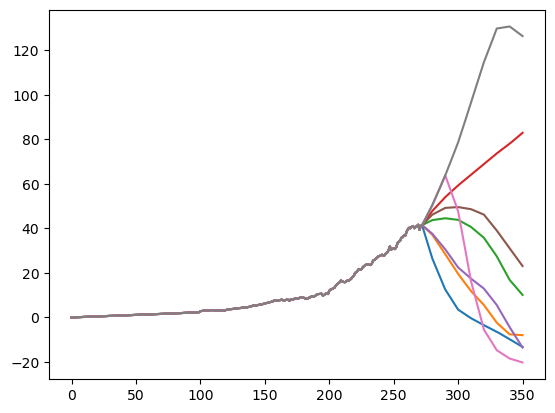

In [6]:
pl.plot(emissions);

In [7]:
co2_concentration = f.concentration.sel(specie="CO2").rolling(timebounds=2, min_periods=2, center=True).mean().median(dim="config").dropna("timebounds")

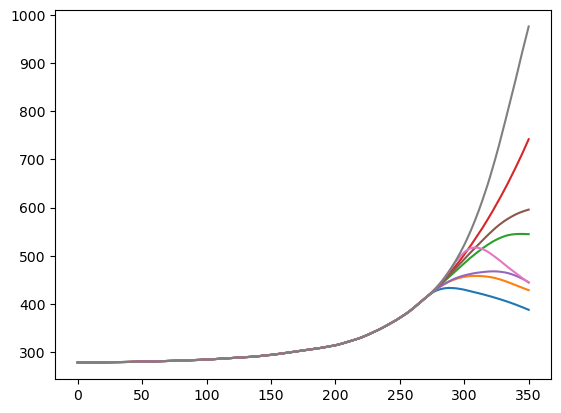

In [8]:
pl.plot(co2_concentration);

In [9]:
forcing_sum = f.forcing_sum.rolling(timebounds=2, min_periods=2, center=True).mean().median(dim="config").dropna("timebounds")

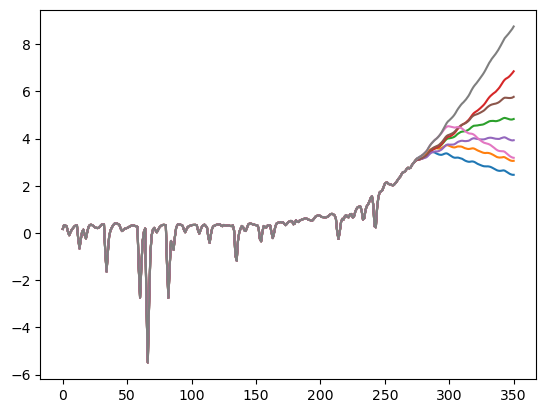

In [10]:
pl.plot(forcing_sum);

In [11]:
non_co2_forcing = (f.forcing_sum - f.forcing.sel(specie="CO2")).rolling(timebounds=2, min_periods=2, center=True).mean().median(dim="config").dropna("timebounds")

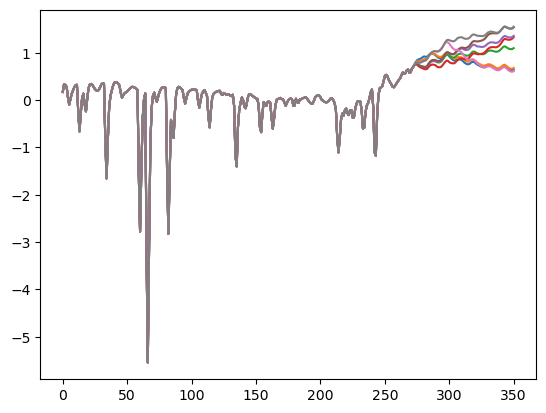

In [12]:
pl.plot(non_co2_forcing);

In [13]:
co2_forcing = f.forcing.sel(specie="CO2").rolling(timebounds=2, min_periods=2, center=True).mean().median(dim="config").dropna("timebounds")

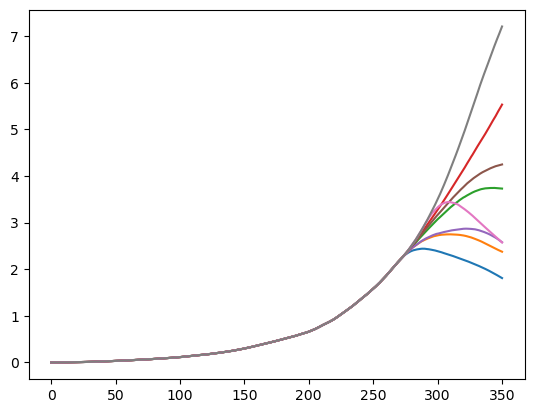

In [14]:
pl.plot(co2_forcing);

In [15]:
temperature_1850_1900_baseline = f.temperature.sel(
#    layer=0, 
    timebounds=np.arange(1850, 1902)
).rolling(timebounds=2, min_periods=2, center=True).mean().dropna("timebounds").mean(dim="timebounds")

In [16]:
temperature = (
    f.temperature - temperature_1850_1900_baseline
).sel(layer=0).rolling(timebounds=2, min_periods=2, center=True).mean().median(dim="config").dropna("timebounds")





# temperature = (0.5 * 
#     (
#         (
#             (f.temperature[1:, :, :, 0] + f.temperature[:-1, :, :, 0]) -
#             (f.temperature[100:151, :, :, 0] + f.temperature[101:152, :, :, 0]).mean(dim="timebounds")
#         ).median(dim="config")
#     )
# )

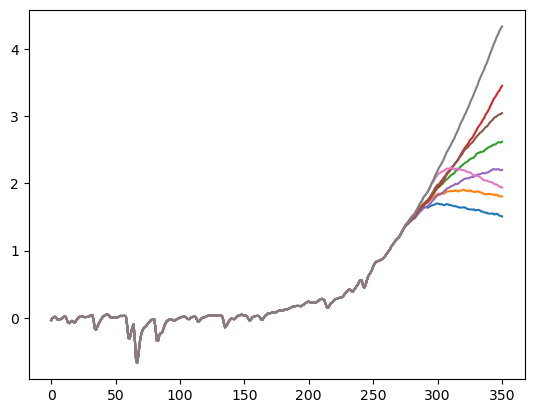

In [17]:
pl.plot(temperature);

In [18]:
os.makedirs('../output', exist_ok=True)

In [19]:
emissions.to_pandas().to_csv('../output/emissions.csv')

In [20]:
co2_concentration.to_pandas().set_index(pd.Index(np.arange(1750.5, 2101), name='timepoints')).to_csv('../output/co2_concentration.csv')

In [21]:
forcing_sum.to_pandas().set_index(pd.Index(np.arange(1750.5, 2101), name='timepoints')).to_csv('../output/forcing_sum.csv')

In [22]:
co2_forcing.to_pandas().set_index(pd.Index(np.arange(1750.5, 2101), name='timepoints')).to_csv('../output/co2_forcing.csv')

In [23]:
non_co2_forcing.to_pandas().set_index(pd.Index(np.arange(1750.5, 2101), name='timepoints')).to_csv('../output/non_co2_forcing.csv')

In [24]:
temperature.to_pandas().set_index(pd.Index(np.arange(1750.5, 2101), name='timepoints')).to_csv('../output/temperature.csv')